In [1]:
# Load Modules
import os
import numpy as np
import json
import math

# import seaborn as sns
# sns.set()

#from tqdm.notebook import tqdm

# Pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


# cuda setup, set seed for reproducability 
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_seed(41)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print(f"Using device: {device}")


# YOU NEED THIS TO LOAD PyTorch Lightning I DON"T KNOW WHY

from jupyter_client.manager import KernelManager

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Set torch dtype to float64
torch.set_default_dtype(torch.float64)


Using device: cpu


/home/tdmonkman/anaconda3/envs/please_work/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/tdmonkman/anaconda3/envs/please_work/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline



# Set data path

In [4]:
# Modules for loading data, set data pathimport urllib
DATASET_PATH = "cloudimages"
CHECKPOINT_PATH = os.getcwd()
DRIVE_PATH = "."

# Import custom npy loader
import sys
sys.path.append(f"{DRIVE_PATH}/")
from import_npy import npy_loader



# Look at example pic


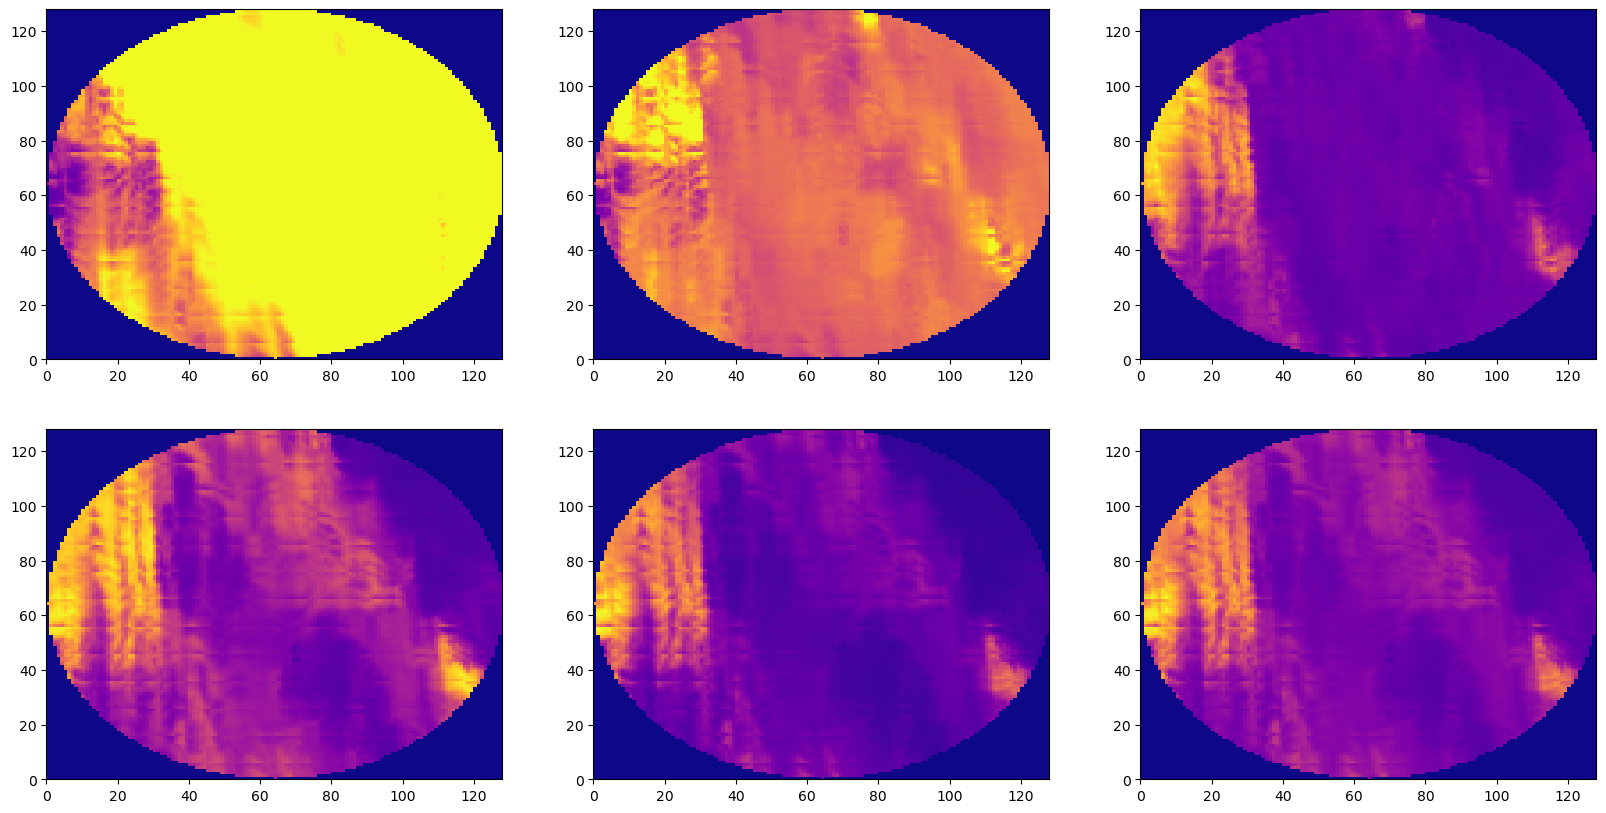

In [5]:
img_index = 3
group = 1

file = os.listdir(f"{DRIVE_PATH}/{DATASET_PATH}/{group}")[img_index]
img_example = np.load(f"{DRIVE_PATH}/{DATASET_PATH}/{group}/{file}",allow_pickle=True)

fig, axs = plt.subplots(2,3,figsize=(20,10))

axs[0,0].pcolor(img_example[:,:,0],cmap="plasma")
axs[0,1].pcolor(img_example[:,:,1],cmap="plasma")
axs[0,2].pcolor(img_example[:,:,2],cmap="plasma")

axs[1,0].pcolor(img_example[:,:,3],cmap="plasma")
axs[1,1].pcolor(img_example[:,:,4],cmap="plasma")
axs[1,2].pcolor(img_example[:,:,5],cmap="plasma")

plt.show()
plt.close()

# Define the DataLoaders

In [6]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets

# Here we use our custom function imported from the drive directory (import_npy.py)
AICCA_data = datasets.DatasetFolder(root=f"{DRIVE_PATH}/{DATASET_PATH}",
                                    loader=npy_loader,
                                    extensions=['.npy'])
    

print(AICCA_data)
print("classes")
print(AICCA_data.classes)
print("class_dict")
print(AICCA_data.class_to_idx)

# Data loader works her
# Split into train, validation, and test data
train_length = int(0.7*len(AICCA_data))
validation_length = int(0.2*len(AICCA_data))
test_length = len(AICCA_data) - train_length - validation_length

# Split
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(AICCA_data, (train_length, validation_length, test_length))

# Verify size of datasets
print(f"size train_dataset: {len(train_dataset)}")
print(f"size validation_dataset: {len(validation_dataset)}")
print(f"size test_dataset: {len(test_dataset)}")

# 
train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False, pin_memory=True,num_workers=1)
val_loader = data.DataLoader(validation_dataset, batch_size=128, shuffle=False, drop_last=False, pin_memory=True,num_workers=1)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False, pin_memory=True,num_workers=1)

Dataset DatasetFolder
    Number of datapoints: 62892
    Root location: ./cloudimages
classes
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']
class_dict
{'1': 0, '10': 1, '11': 2, '12': 3, '13': 4, '14': 5, '15': 6, '16': 7, '17': 8, '18': 9, '19': 10, '2': 11, '20': 12, '21': 13, '22': 14, '23': 15, '24': 16, '25': 17, '26': 18, '27': 19, '28': 20, '29': 21, '3': 22, '30': 23, '31': 24, '32': 25, '33': 26, '34': 27, '35': 28, '36': 29, '37': 30, '38': 31, '39': 32, '4': 33, '40': 34, '41': 35, '42': 36, '5': 37, '6': 38, '7': 39, '8': 40, '9': 41}
size train_dataset: 44024
size validation_dataset: 12578
size test_dataset: 6290


# Try randomly sampling images

Image shape: torch.Size([128, 128, 6])
Image datatype: torch.float64
Image label: 37
Label datatype: <class 'int'>


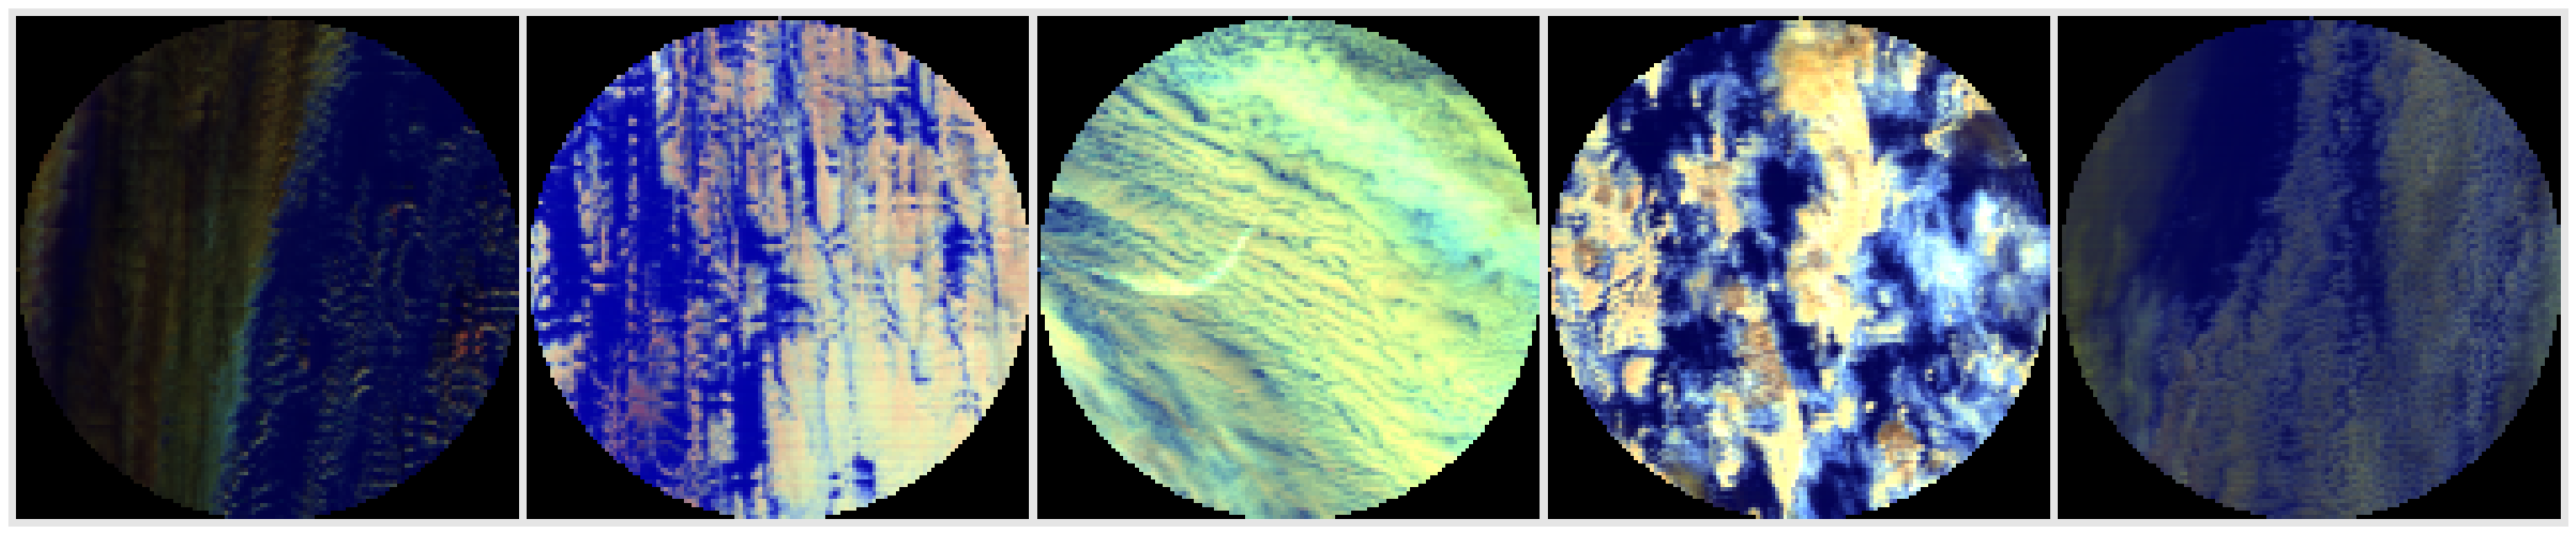

In [7]:
img, label = train_dataset[0][0], train_dataset[0][1]
#print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

NUM_IMAGES = 5

cloud_images = torch.stack([test_dataset[idx][0] for idx in np.random.randint(0,high=test_length,size=NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(torch.permute(cloud_images[:,:,:,[0,1,2]],(0,3,1,2)), nrow=NUM_IMAGES, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1,2,0)

plt.figure(figsize=(10*NUM_IMAGES,8))
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [2]:
128*128/(8*8)

256.0

# Transform images to patches

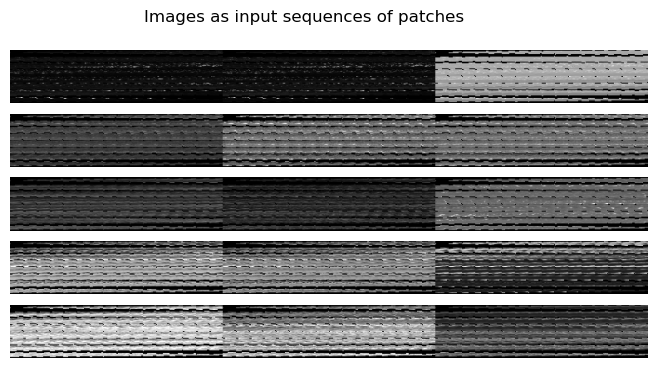

In [8]:
# Function for preprocessing the images into patches
def imgs_to_patches(imgs, patch_size, flatten_channels=True):
    """
    Inputs
    ------
    imgs: torch.Tensor containing the images of shape (Num Images, Channels, Height, Width)
    patch_size: 
    flatten_channels: False
    
    Outputs
    -------
    imgs: 
    """
    # Reshape the image tensor to shape (image, channel, height, width) 
    imgs = imgs.permute(0,3,1,2)
    B, C, H, W = imgs.shape
    # Divide images into patches
    imgs = imgs.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    # Reshape images to shape (image, patch, channel, height, width)
    imgs = imgs.permute(0,2,4,1,3,5)
    imgs = imgs.flatten(1,2)
    # You can flatten the patches into a "feature vector" if you wouldlike
    if flatten_channels:
        imgs = imgs.flatten(2,4)
    return imgs
    
    
cloud_images = torch.stack([test_dataset[idx][0][:,:,:3] for idx in np.random.randint(0,high=test_length,size=NUM_IMAGES)], dim=0)
img_patches = imgs_to_patches(cloud_images, 16)

# Plot examples
fig, ax = plt.subplots(cloud_images.shape[0], 1, figsize=(20,4))
fig.suptitle("Images as input sequences of patches")
for i in range(cloud_images.shape[0]):
  img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
  img_grid = img_grid.permute(1,2,0)
  ax[i].imshow(img_grid)
  ax[i].axis('off')

plt.show()
plt.close()

In [11]:
print(128/4)
print(128/8)
print(128/16)
print(128/32)
print(128/64)

32.0
16.0
8.0
4.0
2.0


# Attention Block Prototype
see https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html

In [9]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs
        ------
        embed_dim: Dimensionality of input and attention feature vectors
        hidden_dim: Dimensionality of hidden layer in feed-forward network
                    (usually 2 to 4x larger than embed_dim)
        num_heads: Number of heads to use in the Multi-Head Attention block
        dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__() # super() is a function that allows you to initialize 
                           # attributes from the parent class
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        # nn.LayerNorm applies layer normalization over a mini-batch of inputs as
        # described in the AttentionBlock paper. Uses the expectation value and 
        # mean to calculate them over the last D-dimensions where D is the 
        # dimension of the 'normalized_shape.'
        
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        # nn.MultiheadAttention applies the multiheaded attention layer from the
        # Attention paper. 'embed_dim' and 'num_heads' are self-explanatory.
        # During training, dropout randomly zeros some of the elements of the 
        # input tensor with probability p using samples from a Bernoulli 
        # distribution. Each channel will be zeroed out independently on
        # every forward call. This is an effective technique for regularization
        # and preventing the co-adaption of neurons.
        
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        # take the norm again
        
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        # run the attention block
        input_x = self.layer_norm_1(x)
        x = x + self.attn(input_x, input_x, input_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

## Build the Vision Transformer
Besides the transformer, we need a couple more modules:
*    A linear projection layer that maps the input patches to a feature vector of larger size. It is implemented by a linear layer that takes each MxM patch independently as input.
*    A classification token that is added to the input sequence. We will use the output feature vector of the classification token (CLS token) for determining the classification prediction.
*    Learnable positional encodings that are added to the tokens before being processed by the transformer. Those are needed to learn position-dependent information, and convert the set to a sequence. SINCE WE ARE WORKING WITH A FIXED RESOLUTION, WE CAN LEARN THE POSITIONAL ENCODINGS INSTEAD OF HAVING THE PATTERN OF SINE AND COSINE FUNCTIONS!
*    An MLP head that takes the output feature vector of the CLS token, and maps it to a classification prediction. This is usually inmplemented by a small feed-forward network or even a single linear layer. 



In [10]:
class VisionTransformer(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs
        ------
        embed_dim: Dimensionality of the input feature vectors to the Transformer
        hidden_dim: Dimensionality of the hidden layer in the feed-forward networks
                     within the Transformer
        num_channels: Number of channels of the input (3 for RGB)
        num_heads: Number of heads to use in the Multi-Head Attention block
        num_layers: Number of layers to use in the Transformer
        num_classes: Number of classes to predict
        patch_size: Number of pixels that the patches have per dimension
        num_patches: Maximum number of patches an image can have
        dropout: Amount of dropout to apply in the feed-forward network and
                  on the input encoding
        
        Dependencies
        ------------
        
        """
        super().__init__()
        
        self.patch_size = patch_size
        
        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for layer in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)
        
        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
        
    def forward(self, img):
        # Preprocess input
        img = imgs_to_patches(img, self.patch_size)
        B, T, _ = img.shape
        img = self.input_layer(img)
        
        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        img = torch.cat([cls_token, img], dim=1)
        img = img + self.pos_embedding[:,:T+1]
        
        # Apply Transformer
        img = self.dropout(img)
        img = img.transpose(0,1)
        img = self.transformer(img)
        
        # Perform classification prediction
        cls = img[0]
        out = self.mlp_head(cls)
        return out
    
    


## Put everything into a PyTorch Lightning Module

We use AdamW as the optimizer, which is Adam with a corrected weight decay implementation. Since we apply the Pre-LN Transformer version, we do not need to use a learning rate warmup stage. Instead, we use the same learning rate scheduler as the CNNs in our previous tutorial on image classification.

In [11]:
from lightning_fabric.utilities import optimizer

class ViT(pl.LightningModule):

    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")



def train_model(training_checkpoint_path,**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=180,
                         callbacks=[ModelCheckpoint(save_weights_only=True, verbose=True, save_last=True, mode="max", monitor="val_acc", every_n_train_steps=10),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ViT.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    
    elif os.path.isfile(training_checkpoint_path):
        print(f"Found checkpoint at {training_checkpoint_path}")
        model = ViT.load_from_checkpoint(training_checkpoint_path) # Load best checkpoint after training
        trainer.fit(model, train_loader, val_loader)
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    else:
        print("Running from scratch")
        pl.seed_everything(42) # To be reproducable
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [15]:
def train_model(training_checkpoint_path,**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=180,
                         callbacks=[ModelCheckpoint(save_weights_only=True, verbose=True, save_last=True, mode="max", monitor="val_acc", every_n_train_steps=100),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    print(f"cwd: {os.getcwd()}")
    print(f"CHECKPOINT_PATH: {CHECKPOINT_PATH}")
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ViT.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    
    elif os.path.isfile(CHECKPOINT_PATH):
        print(f"Found checkpoint at {CHECKPOINT_PATH}")
        model = ViT.load_from_checkpoint(CHECKPOINT_PATH) # Load best checkpoint after training
        trainer.fit(model, train_loader, val_loader)
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    else:
        print("Running from scratch")
        pl.seed_everything(42) # To be reproducable
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [16]:
CHECKPOINT_PATH

'/scratch/midway2/tdmonkman/AICCA_proj'

# Train the model here

In [ ]:
model, results =     train_model( '/scratch/midway2/tdmonkman/AICCA_proj', model_kwargs={
                                    'embed_dim': 256,
                                    'hidden_dim': 512,
                                    'num_heads': 8,
                                    'num_layers': 6,
                                    'patch_size': 16,
                                    'num_channels': 6,
                                    'num_patches': 64,
                                    'num_classes': 42,
                                    'dropout': 0.2
                                }, lr=3e-4,)


print("ViT results", results)

/home/tdmonkman/anaconda3/envs/please_work/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/tdmonkman/anaconda3/envs/please_work/lib/pytho ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tdmonkman/anaconda3/envs/please_work/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorbo

cwd: /scratch/midway2/tdmonkman/AICCA_proj
CHECKPOINT_PATH: /scratch/midway2/tdmonkman/AICCA_proj
Running from scratch


/home/tdmonkman/anaconda3/envs/please_work/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/tdmonkman/anaconda3/envs/please_work/lib/pytho ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | In sizes           | Out sizes
-----------------------------------------------------------------------------
0 | model | VisionTransformer | 3.6 M  | [128, 128, 128, 6] | [128, 42]
-----------------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.337    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/tdmonkman/anaconda3/envs/please_work/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tdmonkman/anaconda3/envs/please_work/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/tdmonkman/anaconda3/envs/please_work/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='val_acc')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'epoch', 'step']. HINT: Did you call `log('val_acc', value)` in the `LightningModule`?
  warning_cache.warn(m)
Epoch 0, global step 100: 'val_acc' was not in top 1
Epoch 0, global step 200: 'val_acc' was not in top 1
Epoch 0, global step 300: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 400: 'val_acc' reached 0.67984 (best 0.67984), saving model to '/scratch/midway2/tdmonkman/AICCA_proj/ViT/lightning_logs/version_4/checkpoints/epoch=1-step=400.ckpt' as top 1
Epoch 1, global step 500: 'val_acc' was not in top 1
Epoch 1, global step 600: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 700: 'val_acc' reached 0.70520 (best 0.70520), saving model to '/scratch/midway2/tdmonkman/AICCA_proj/ViT/lightning_logs/version_4/checkpoints/epoch=2-step=700.ckpt' as top 1
Epoch 2, global step 800: 'val_acc' was not in top 1
Epoch 2, global step 900: 'val_acc' was not in top 1
Epoch 2, global step 1000: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 1100: 'val_acc' reached 0.73756 (best 0.73756), saving model to '/scratch/midway2/tdmonkman/AICCA_proj/ViT/lightning_logs/version_4/checkpoints/epoch=3-step=1100.ckpt' as top 1
